In [1]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
import netCDF4 as nc
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')
import rasotools
# from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua4 as eua
# eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings('ignore')

from inspect import getmembers, isfunction


from IPython.display import Image
from IPython.core.display import HTML 
import rasotools


no config found


In [8]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)



# x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
# gauss=x/6+y/6
# clist=numpy.linspace(-1,1,26)
# plt.contourf(x,y,gauss,clist,cmap=cmnew)
# plt.colorbar()
# plt.show()
# print('ready')

def plt_trends(lla,pdict,var='_',bias='_', marker_size = 510, marker_shape = 's', alpha=0.8, cold_positive=False, scale_limit=2, titel = ''):


    rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
    "rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
    "rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
    "rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
    "rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
    "rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
    "rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
    "rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
    "rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]

    if cold_positive:
        rgblist = np.flip(rgblist)
    rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

    cmnew=make_colormap(rgblist2)

    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)

    if 'scale' not in pdict.keys():
        pdict['scale']=scale_limit
    a = rasotools.plot._helpers.cost(lla[2],lla[1],lla[0])
    cost = np.sum(a)/len(a)

    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax._autoscaleXon = False
    ax._autoscaleYon = False

    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

    plt.scatter(lla[2], lla[1], s=marker_size, alpha=alpha,
                c= lla[0],
                cmap=cmnew,
                vmin=-pdict['scale'],
                vmax=pdict['scale'],
                marker = marker_shape,
                edgecolor='k',)
    plt.colorbar(orientation='horizontal', label='Trend '+pdict['units'], shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.title(titel + str(pdict['pl'])+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(len(lla[0])))
        
    try:
        os.mkdir('plots_new')
    except:
        pass
#     plt.savefig('plots_new/cuon_'+names[bias]+'_'+str(pdict['start'])+'-'+str(pdict['stop'])+'_'+str(pdict['pl']), bbox_inches='tight')
    plt.show()
    plt.close()



pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = [12, 8]

def plot_world_map(file, mission_channel, marker_size = 510, marker_shape = 's', alpha = 0.8, cold_positive=False, scale_limit=2, units=r'K/10a', titel = ''):
    trends = pickle.load( open( file, "rb" ) )
    lats = []
    lons = []
    vals = []
    minl = []
    maxl =[]

    for i in trends:
        if trends[i] >= 15:
            maxl.append([i, trends[i]])
        elif trends[i] <= -15:
            minl.append([i, trends[i]])
        else:
            lats.append(float( i.split('_')[0]))#trends[i].lat))
            lons.append(float( i.split('_')[1]))#trends[i].lon))
            # vals.append(float(trends[i].values))
            vals.append(float(trends[i]))
    # print(' --- dropped ---')
    # print(maxl)
    # print(minl)
    # /10. for K/10a
    plt_trends(np.array([np.array(vals)/10., np.array(lats), np.array(lons)]), dict(var='temperature',pl=mission_channel,start='1999',stop='2010',units=units), marker_size = marker_size, marker_shape = marker_shape, alpha=alpha, cold_positive=cold_positive, scale_limit=scale_limit, titel=titel)
#     rasotools.plot.map.points(lon=np.array(lons), lat=np.array(lats), values=np.array(vals), vmin=-5, vmax=5)
    plt.show()
    plt.close()

In [3]:
# station = '/mnt/users/scratch/leo/scratch/converted_v13/long/0-20001-0-11035_CEUAS_merged_v1.nc'
# df = eua.CDMDataset(filename = station).to_dataframe(
#     groups=['observations_table', 'advanced_homogenisation'], 
#     variables=['observed_variable', 'observation_value', 'date_time', 'z_coordinate', 'latitude', 'longitude','humidity_bias_estimate']
#     )
# df = df[np.isin(df.z_coordinate, [20000,25000,30000,40000,50000,70000,85000,92500])]
# df = df.rename({'latitude':'lat','longitude':'lon', 'date_time':'time', 'z_coordinate':'plev'}, axis='columns')
# all_dfsh = df[df.observed_variable == 138]
# all_dfsh = all_dfsh.rename({'observation_value':'rh'}, axis='columns')

# all_dfta = df[df.observed_variable == 126]
# all_dfta = all_dfta.rename({'observation_value':'temperature'}, axis='columns')

# df_target = pd.merge(all_dfsh, all_dfta, on=["time", "plev", "lat", "lon"])

# df_target['sh'] = rasotools.met.convert.to_sh(temp=xr.DataArray(df_target.temperature), press=xr.DataArray(df_target.plev), rel_humi=xr.DataArray(df_target.rh)).values
# df_target['sh'][np.logical_or((df_target['sh'] < 0.), (df_target['sh'] > 1.03))] = np.nan
# df_target['sh_adj'] = rasotools.met.convert.to_sh(temp=xr.DataArray(df_target.temperature), press=xr.DataArray(df_target.plev), rel_humi=xr.DataArray(df_target.rh - df_target.humidity_bias_estimate_x)).values
# df_target['sh_adj'][np.logical_or((df_target['sh_adj'] < 0.), (df_target['sh_adj'] > 1.03))] = np.nan
# df_sh = df[df.observed_variable == 39]

## All the different specific humidities:

In [4]:
# plt.plot(df_target.time, df_target.sh, color = 'red', alpha = 0.6, label='sh')
# plt.plot(df_target.time, df_target.sh_adj, color = 'blue', alpha = 0.6, label='adj_sh')
# plt.plot(df_sh.time, df_sh.observation_value,color = 'green', alpha = 0.6, label='resort_sh')
# plt.legend()

## Subset of the different specific humidities:

In [5]:
# plt.plot(df_target[np.logical_and(df_target.time > '1955' , df_target.time <'1960')].time, df_target[np.logical_and(df_target.time > '1955' , df_target.time <'1960')].sh, color = 'red', alpha = 0.6, label='sh')
# plt.plot(df_target[np.logical_and(df_target.time > '1955' , df_target.time <'1960')].time, df_target[np.logical_and(df_target.time > '1955' , df_target.time <'1960')].sh_adj, color = 'blue', alpha = 0.6, label='adj_sh')
# plt.plot(df_sh[np.logical_and(df_sh.time > '1955' , df_sh.time <'1960')].time, df_sh[np.logical_and(df_sh.time > '1955' , df_sh.time <'1960')].observation_value,color = 'green', alpha = 0.6, label='resort_sh')
# plt.legend()

## Different specific humidities for the most :

In [6]:
# plt.plot(df_target[np.logical_and(df_target.time > '1968' , df_target.time <'1970')].time, df_target[np.logical_and(df_target.time > '1968' , df_target.time <'1970')].sh, color = 'red', alpha = 0.6, label='sh')
# plt.plot(df_target[np.logical_and(df_target.time > '1968' , df_target.time <'1970')].time, df_target[np.logical_and(df_target.time > '1968' , df_target.time <'1970')].sh_adj, color = 'blue', alpha = 0.6, label='adj_sh')
# plt.plot(df_sh[np.logical_and(df_sh.time > '1968' , df_sh.time <'1970')].time, df_sh[np.logical_and(df_sh.time > '1968' , df_sh.time <'1970')].observation_value,color = 'green', alpha = 0.6, label='resort_sh')
# plt.legend()

## "good" check > 0:

In [7]:
# df_target_sh = df_target
# df_target_sh['time_to_show'] = df_target_sh.time
# df_target_sh.index = pd.to_datetime(df_target_sh['time'],format='%y-%m/%d %I:%M%p')
# df_target_sh_copy = copy.deepcopy(df_target_sh)
# df_target_sh = df_target_sh.groupby(by=[df_target_sh.index.month, df_target_sh.index.year, 'plev']).aggregate({"sh":"mean"})
# df_target_sh['count'] = df_target_sh_copy.groupby(by=[df_target_sh_copy.index.month, df_target_sh_copy.index.year, 'plev']).aggregate({'sh':'count'}).values
# df_target_sh['time_to_show'] = np.char.add(np.array(df_target_sh.index.get_level_values(1)).astype('str') , np.char.zfill(np.array(df_target_sh.index.get_level_values(0)).astype('str'), 2))
# df_target_sh['time_to_show'] = pd.to_datetime(df_target_sh['time_to_show'],format='%Y%m')

# for pi in [20000,25000,30000,40000,50000,70000,85000,92500]:
#     xs_sh = df_target_sh.xs(pi, level='plev')
#     xs_sh.sort_values(by='time_to_show', inplace=True)
#     xs_sh = xs_sh[xs_sh['count'] > 0]
#     plt.plot(xs_sh.time_to_show, xs_sh.sh, alpha = 0.6, label='aggregated_sh_' + str(pi))
#     # plt.title(str(pi) + ' Pa')
# plt.legend()
# plt.show()
# plt.close()

## "good" check > 15:

In [8]:
# df_target_sh = df_target
# df_target_sh['time_to_show'] = df_target_sh.time
# df_target_sh.index = pd.to_datetime(df_target_sh['time'],format='%y-%m/%d %I:%M%p')
# df_target_sh_copy = copy.deepcopy(df_target_sh)
# df_target_sh = df_target_sh.groupby(by=[df_target_sh.index.month, df_target_sh.index.year, 'plev']).aggregate({"sh":"mean"})
# df_target_sh['count'] = df_target_sh_copy.groupby(by=[df_target_sh_copy.index.month, df_target_sh_copy.index.year, 'plev']).aggregate({'sh':'count'}).values
# df_target_sh['time_to_show'] = np.char.add(np.array(df_target_sh.index.get_level_values(1)).astype('str') , np.char.zfill(np.array(df_target_sh.index.get_level_values(0)).astype('str'), 2))
# df_target_sh['time_to_show'] = pd.to_datetime(df_target_sh['time_to_show'],format='%Y%m')

# for pi in [20000,25000,30000,40000,50000,70000,85000,92500]:
#     xs_sh = df_target_sh.xs(pi, level='plev')
#     xs_sh.sort_values(by='time_to_show', inplace=True)
#     xs_sh = xs_sh[xs_sh['count'] > 15]
#     plt.plot(xs_sh.time_to_show, xs_sh.sh, alpha = 0.6, label='aggregated_sh_' + str(pi))
#     # plt.title(str(pi) + ' Pa')
# plt.legend()
# plt.show()
# plt.close()

# RTTOV comparison

In [77]:
humfiles = glob.glob('/mnt/jetfs/scratch/uvoggenberger/rttov_out/humidity/bt2_0*.nc')

print(humfiles[0])
df = xr.open_dataset(humfiles[0], decode_times=False).to_dataframe()
df.datum.drop_duplicates()[0,0,0,0,0]

for tslice in ["amsub"]: # , "early"
    time_series = {}

    for station in humfiles[:]:
        # print(station)
        df = xr.open_dataset(station, decode_times=False).to_dataframe()
        ts_index =  str(df.lat.iloc[0]) + '_' + str(df.lon.iloc[0])
        time_series[ts_index] = [[],[],[],[],[]]
        sel_df = df.loc(axis=0)[:, :, [0], :, [0]]
        time_series[ts_index][0].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].montemp.values)
        time_series[ts_index][1].append(df[np.logical_and(df.press == 4 , df.index.get_level_values('hour') == 0)].montemp.values)
        time_series[ts_index][2].append(df[np.logical_and(df.press == 5 , df.index.get_level_values('hour') == 0)].montemp.values)
        time_series[ts_index][3].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].datum.values)
        time_series[ts_index][4].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].goodmon.values)


    trends_ch3 = {}
    trends_ch4 = {}
    trends_ch5 = {}
    for lat_lon in time_series.keys():
        print(lat_lon, len(time_series[lat_lon][0][0]))
        if len(time_series[lat_lon][0][0]) < 10:
            continue
        df2 = pandas.DataFrame(np.transpose(
            [   np.array(time_series[lat_lon][0]).flatten(), 
            np.array(time_series[lat_lon][1]).flatten(), 
            np.array(time_series[lat_lon][2]).flatten(), 
            np.array(time_series[lat_lon][3]).flatten(), 
            np.array(time_series[lat_lon][4]).flatten(), 
            [float(lat_lon.split('_')[0])]*len(np.array(time_series[lat_lon][0]).flatten()), 
            [float(lat_lon.split('_')[1])]*len(np.array(time_series[lat_lon][0]).flatten())
            ]
            ), columns=['ch3', 'ch4', 'ch5', 'time', 'goodmon', 'lat', 'lon'])
        df2.time = [pd.to_datetime('1900-01-01') + pd.Timedelta(x, 'd') for x in df2.time]
        df2.drop_duplicates(subset='time', inplace=True)
        if tslice == "late":
            filter_array = np.logical_or((df2.goodmon < 5), np.logical_or(df2.time.dt.year < 1992 , df2.time.dt.year > 2022)) # < 15 
        if tslice == "early":
            filter_array = np.logical_or((df2.goodmon < 5), np.logical_or(df2.time.dt.year < 1972 , df2.time.dt.year > 2002)) # < 15 
        if tslice == "amsub":
            filter_array = np.logical_or((df2.goodmon < 5), np.logical_or(df2.time.dt.year < 1999 , df2.time.dt.year > 2009)) # < 15 
        df2.ch3[filter_array] = np.nan
        df2.ch4[filter_array] = np.nan
        df2.ch5[filter_array] = np.nan
        df2 = df2.dropna()

        if len(df2) > ((10*12)-24):
            # display(df2)
            xdf = df2.set_index(['time']).to_xarray()
            trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3,only_slopes=True)* 3650) # len(df2.time)*12.*10.)
            trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4,only_slopes=True)* 3650) # len(df2.time)*12.*10.)
            trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5,only_slopes=True)* 3650) # len(df2.time)*12.*10.)

    pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/unadj/hum_unadj_ch3_"+tslice+".p", "wb" ) )
    pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/unadj/hum_unadj_ch4_"+tslice+".p", "wb" ) )
    pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/unadj/hum_unadj_ch5_"+tslice+".p", "wb" ) )

/mnt/jetfs/scratch/uvoggenberger/rttov_out/humidity/bt2_082244.nc
-2.43_-54.72 560
37.9_40.2 792
41.97_21.65 4
47.73_130.97 232
62.91727_152.41629 1664
65.79598_87.99091 1728
36.04706_-115.1847 532
68.70825_-52.85238 1252
32.9_-80.03 1312
78.07_14.22 352
53.0839_158.58379 1820
-66.55711_93.00107 1900
60.36682_120.43084 1660
47.25977_11.35527 1304
33.28_-119.52 76
44.38_-98.22 16
27.33_117.47 2016
41.65689_-69.95888 1280
31.94278_-102.18972 368
42.85_74.53 688
69.77_61.68 864
59.36676_143.20068 1504
38.77_-9.13 776
56.28318_101.75039 1500
33.82_35.48 52
62.53462_113.86817 1400
27.48_95.02 740
50.36656_108.76447 816
54.52746_9.55017 1972
54.3_155.92 960
54.09694_13.40479 2016
65.11677_57.13232 1108
21.36_103.0 56
60.03_-111.93 1704
-2.17_106.13 64
4.02_9.7 432
43.95_81.33 1940
77.71439_104.29301 1228
11.53_-72.93 32
28.45_121.883 552
-12.6776_141.9206 1124
10.92_79.83 992
33.42_36.52 396
15.25_104.87 844
70.9397_-8.66791 1520
53.83_-89.87 336
37.89027_23.74217 1060
0.05_-51.07 568
46.951

In [76]:
humfiles = glob.glob('/mnt/jetfs/scratch/uvoggenberger/rttov_out/humidity_adj/bt2_0*.nc')

print(humfiles[0])
df = xr.open_dataset(humfiles[0], decode_times=False).to_dataframe()
df.datum.drop_duplicates()[0,0,0,0,0]

for tslice in ["amsub"]: # , "early" 
    time_series = {}

    for station in humfiles[:]:
        # print(station)
        df = xr.open_dataset(station, decode_times=False).to_dataframe()
        ts_index =  str(df.lat.iloc[0]) + '_' + str(df.lon.iloc[0])
        time_series[ts_index] = [[],[],[],[],[]]
        sel_df = df.loc(axis=0)[:, :, [0], :, [0]]
        time_series[ts_index][0].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].montemp.values)
        time_series[ts_index][1].append(df[np.logical_and(df.press == 4 , df.index.get_level_values('hour') == 0)].montemp.values)
        time_series[ts_index][2].append(df[np.logical_and(df.press == 5 , df.index.get_level_values('hour') == 0)].montemp.values)
        time_series[ts_index][3].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].datum.values)
        time_series[ts_index][4].append(df[np.logical_and(df.press == 3 , df.index.get_level_values('hour') == 0)].goodmon.values)


    trends_ch3 = {}
    trends_ch4 = {}
    trends_ch5 = {}
    for lat_lon in time_series.keys():
        print(lat_lon, len(time_series[lat_lon][0][0]))
        if len(time_series[lat_lon][0][0]) < 10:
            continue
        df2 = pandas.DataFrame(np.transpose(
            [   np.array(time_series[lat_lon][0]).flatten(), 
            np.array(time_series[lat_lon][1]).flatten(), 
            np.array(time_series[lat_lon][2]).flatten(), 
            np.array(time_series[lat_lon][3]).flatten(), 
            np.array(time_series[lat_lon][4]).flatten(), 
            [float(lat_lon.split('_')[0])]*len(np.array(time_series[lat_lon][0]).flatten()), 
            [float(lat_lon.split('_')[1])]*len(np.array(time_series[lat_lon][0]).flatten())
            ]
            ), columns=['ch3', 'ch4', 'ch5', 'time', 'goodmon', 'lat', 'lon'])
        df2.time = [pd.to_datetime('1900-01-01') + pd.Timedelta(x, 'd') for x in df2.time]
        df2.drop_duplicates(subset='time', inplace=True)
        if tslice == "late":
            filter_array = np.logical_or((df2.goodmon < 15), np.logical_or(df2.time.dt.year < 1992 , df2.time.dt.year > 2022))
        if tslice == "early":
            filter_array = np.logical_or((df2.goodmon < 15), np.logical_or(df2.time.dt.year < 1972 , df2.time.dt.year > 2002))
        if tslice == "amsub":
            filter_array = np.logical_or((df2.goodmon < 5), np.logical_or(df2.time.dt.year < 1999 , df2.time.dt.year > 2010)) # < 15 
        df2.ch3[filter_array] = np.nan
        df2.ch4[filter_array] = np.nan
        df2.ch5[filter_array] = np.nan
        df2 = df2.dropna()
        if len(df2) > ((10*12)-24):
            xdf = df2.set_index(['time']).to_xarray()
            trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3,only_slopes=True)*3650) # len(df2.time)*12.*10.)
            trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4,only_slopes=True)*3650) # len(df2.time)*12.*10.)
            trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5,only_slopes=True)*3650) # len(df2.time)*12.*10.)

    pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/adj/hum_adj_ch3_"+tslice+".p", "wb" ) )
    pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/adj/hum_adj_ch4_"+tslice+".p", "wb" ) )
    pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/adj/hum_adj_ch5_"+tslice+".p", "wb" ) )

/mnt/jetfs/scratch/uvoggenberger/rttov_out/humidity_adj/bt2_082678_hbe.nc
-6.76131_-43.00336 140
-9.80637_-139.03577 308
46.77166_-100.76158 1320
58.31768_82.95059 1708
30.38_-9.57 272
26.6847_-80.0994 36
30.33_76.47 648
4.82201_-52.36539 304
52.8152_9.9247 1616
23.72_113.08 1232
55.3555_78.30662 1808
12.05_8.53 192
41.83_59.97 792
36.09821_-79.94298 1304
56.97_24.05 904
41.13_121.12 1104
23.07_72.63 716
78.92321_11.92314 1388
46.86812_-68.01354 1324
33.35611_-84.56722 1296
59.4545_112.58687 1912
56.5422_3.2236 608
66.76614_123.39874 1724
-30.0_-51.18 1360
26.1_91.58 856
48.4443_-4.41244 312
51.20167_-1.80583 1512
32.35_-94.65 16
47.02_28.98 764
-43.95_-176.57 588
44.90955_-123.00944 1308
-23.33_-51.13 360
72.37939_52.72751 1636
60.41475_77.88258 1316
36.15_-5.35 1128
53.55_-2.92 288
47.68159_-117.62662 1312
40.78_114.88 292
53.83_-89.87 412
56.91614_118.36546 936
59.31904_39.92451 1420
19.9_-75.13 32
12.13_15.03 340
32.37_36.25 916
55.19953_165.9826 1128
-67.67_45.85 708
-17.7_168.3 4

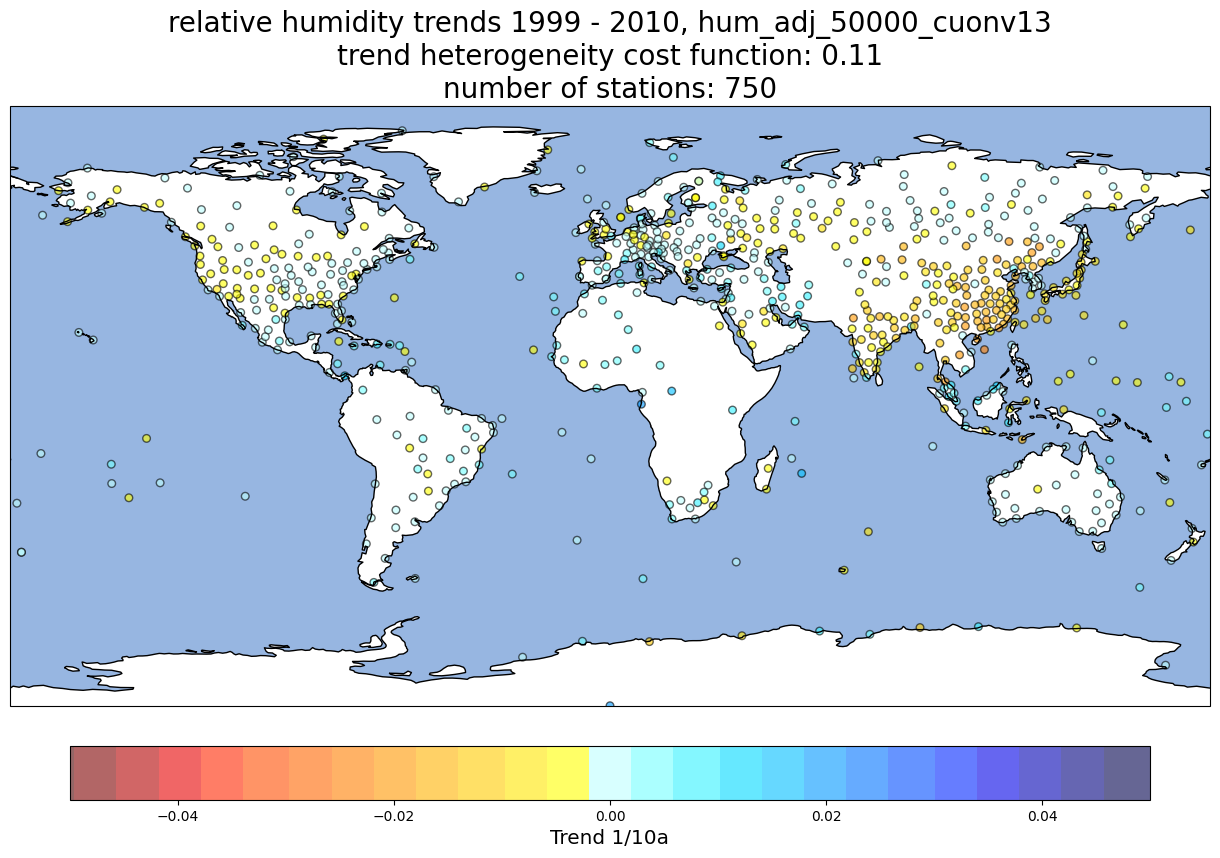

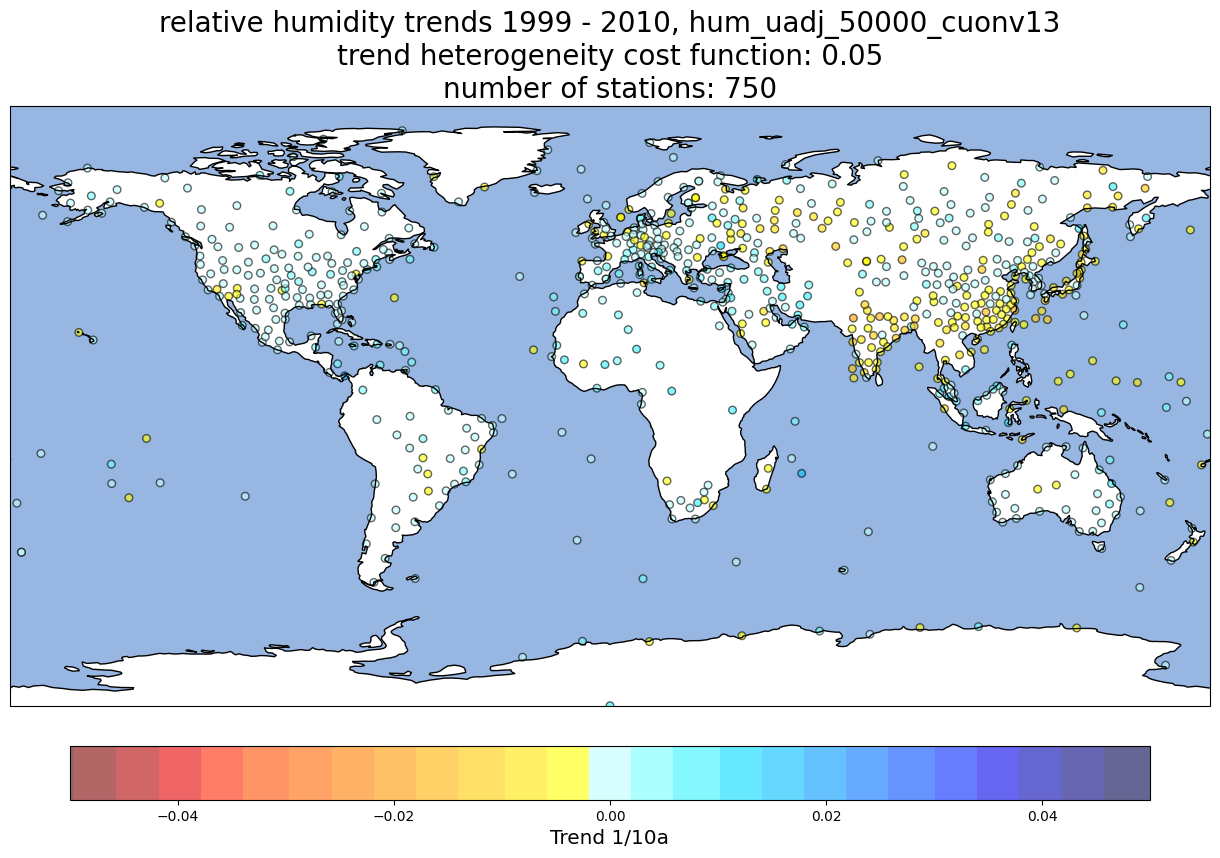

In [11]:
files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/*50000_cuonv13.p')
files = np.sort(files)
for i in files:
    plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 30, marker_shape = 'o', alpha = 0.6, cold_positive=True, scale_limit=0.05, units = r'1/10a', titel='relative humidity trends 1999 - 2010, ')

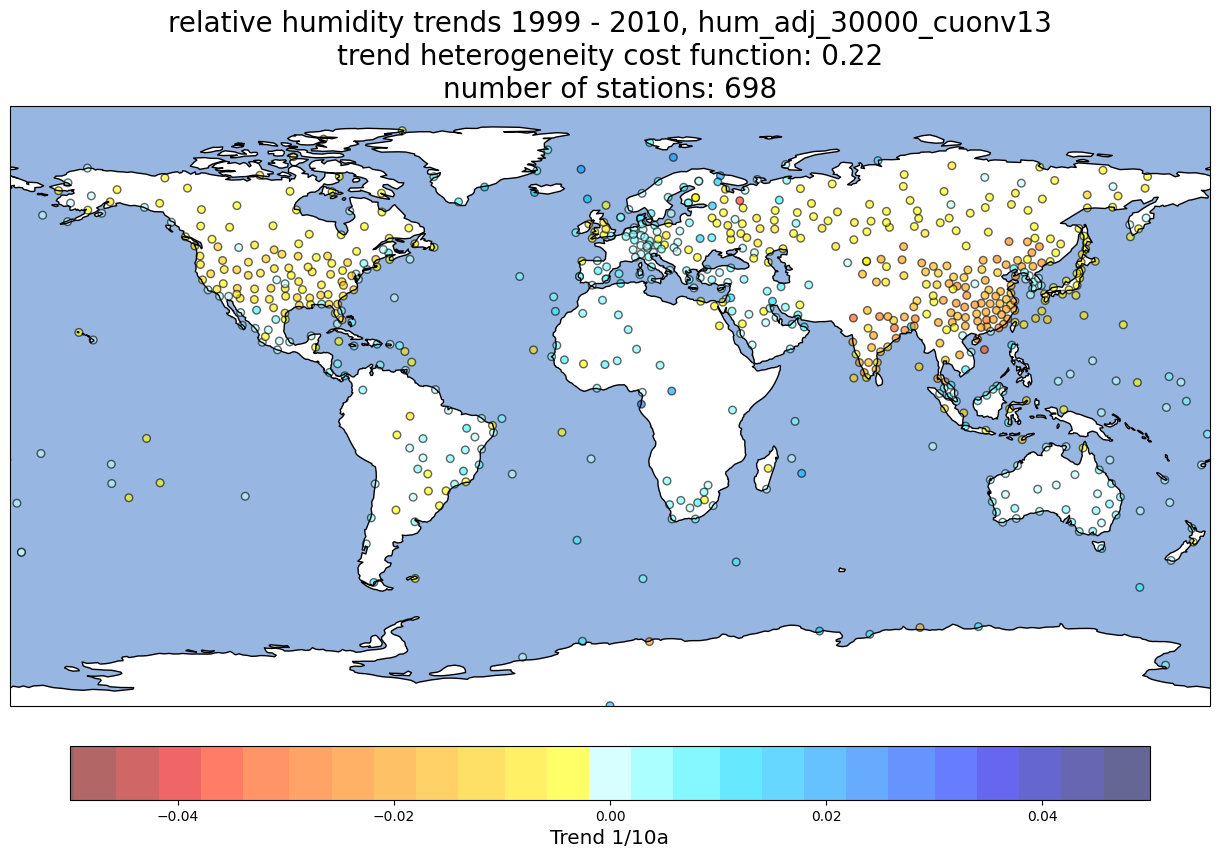

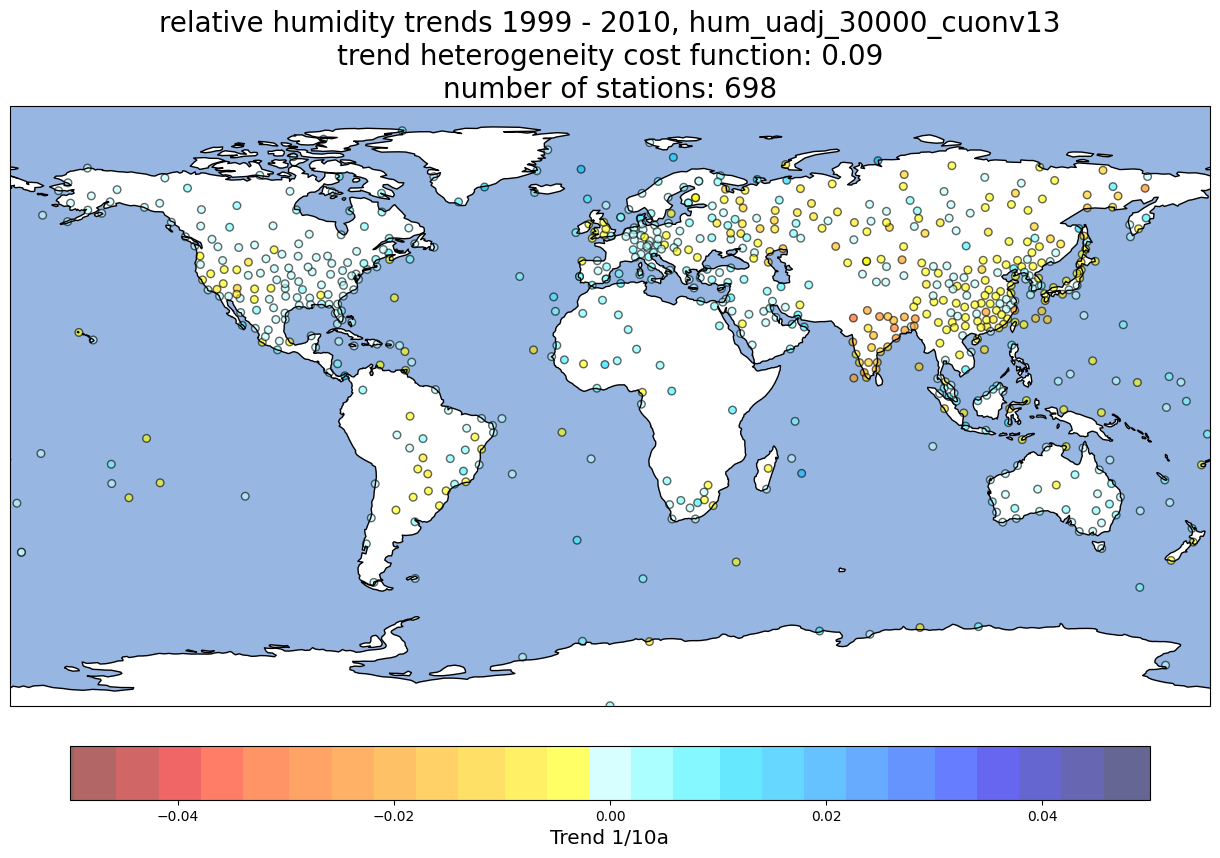

In [12]:
files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/*30000_cuonv13.p')
files = np.sort(files)
for i in files:
    plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 30, marker_shape = 'o', alpha = 0.6, cold_positive=True, scale_limit=0.05, units = r'1/10a', titel='relative humidity trends 1999 - 2010, ')

## AMSU-B 12*10 - 24 months

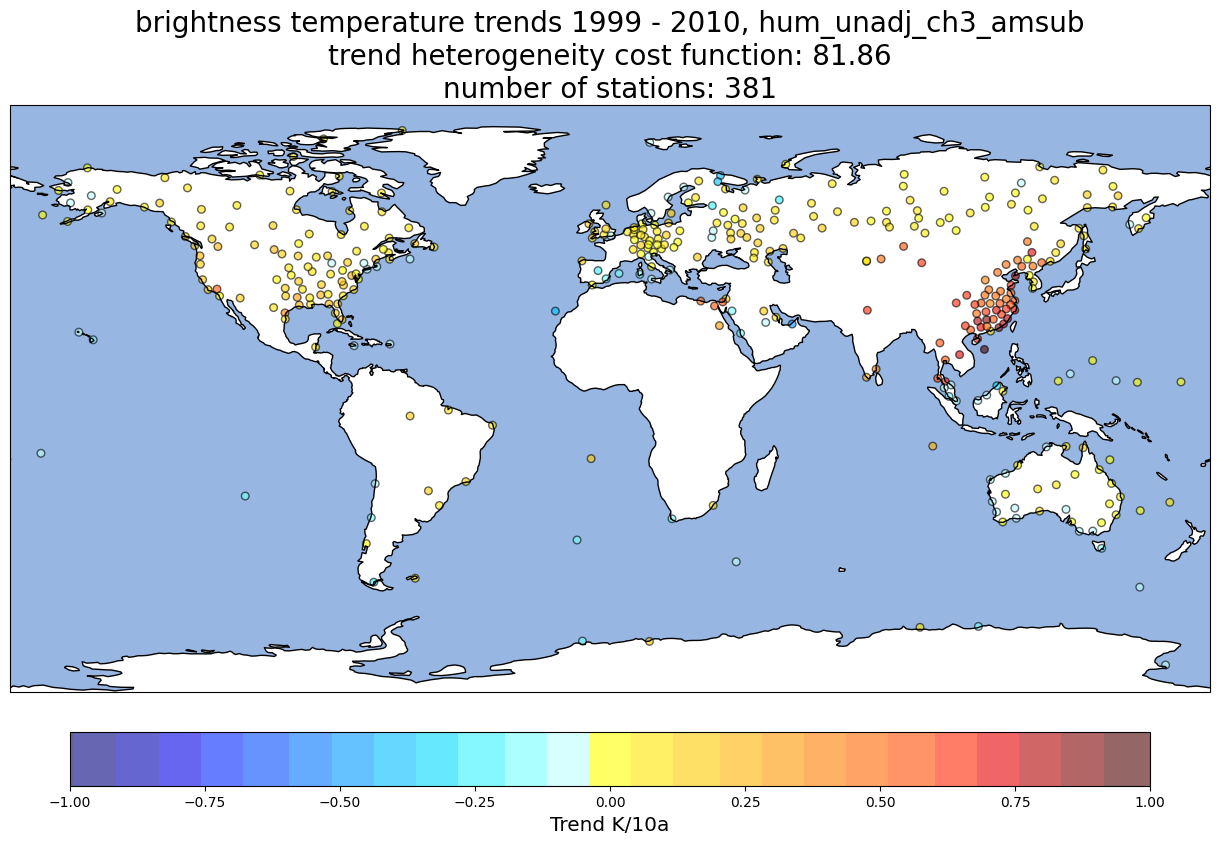

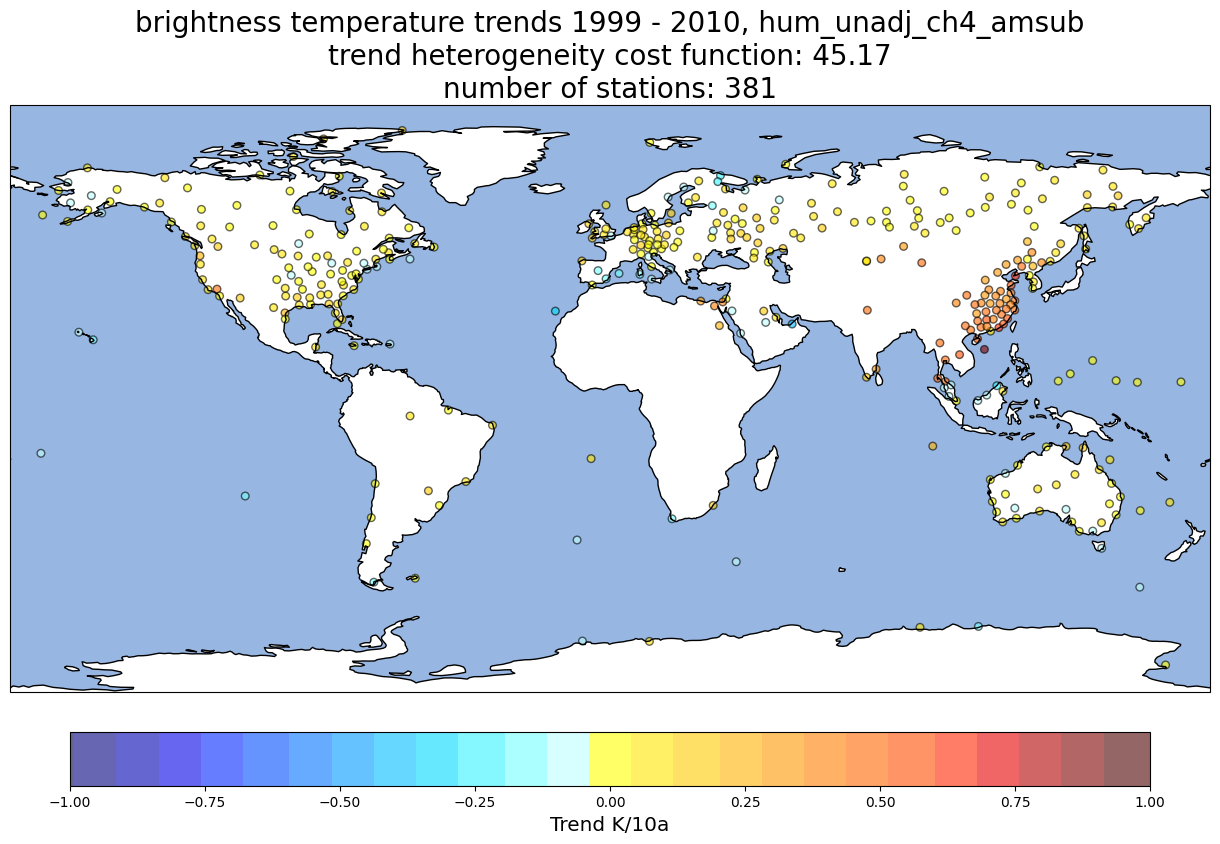

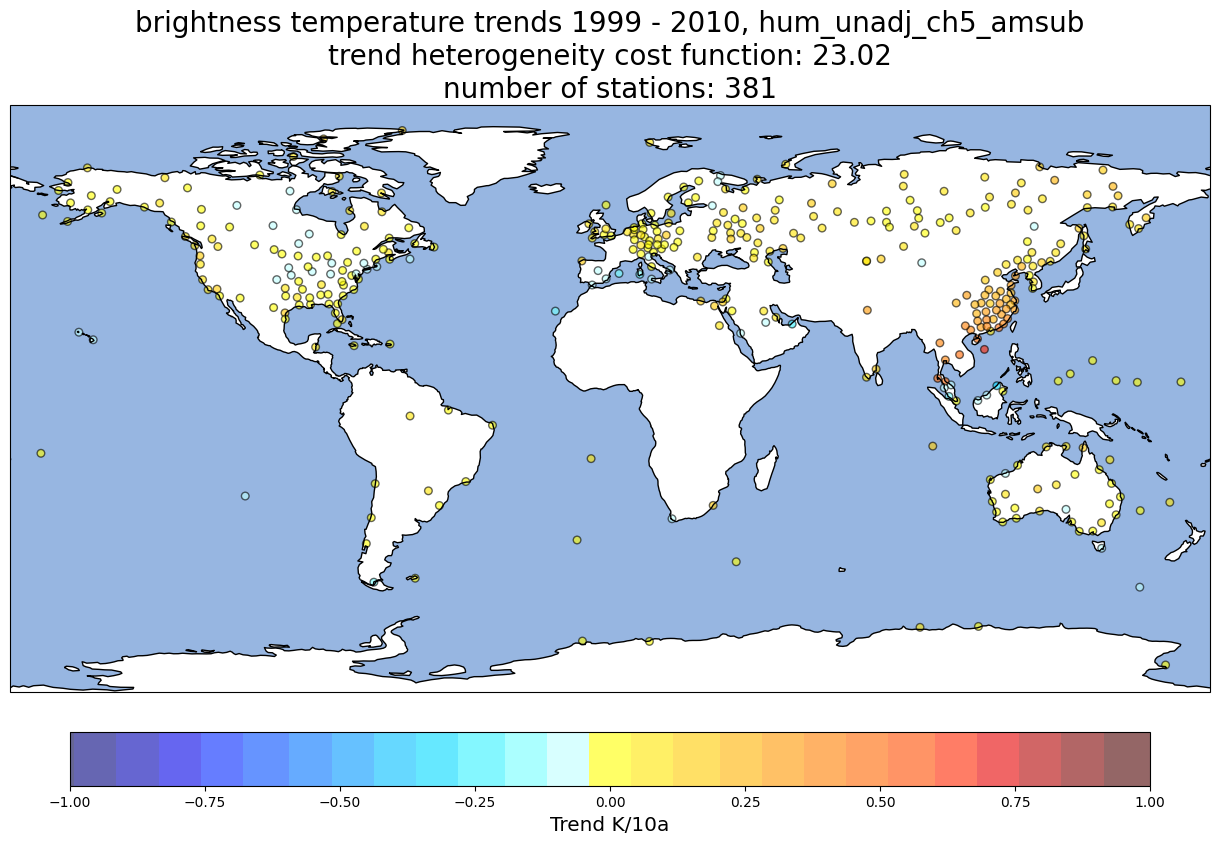

In [17]:
for k in ['ch3', 'ch4', 'ch5']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/unadj/*'+k+'*amsub.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 30, marker_shape = 'o', alpha = 0.6, cold_positive=False, scale_limit=1, units = r'K/10a', titel='brightness temperature trends 1999 - 2010, ')

## AMSU-B ADJUSTED 12*10 - 24 months

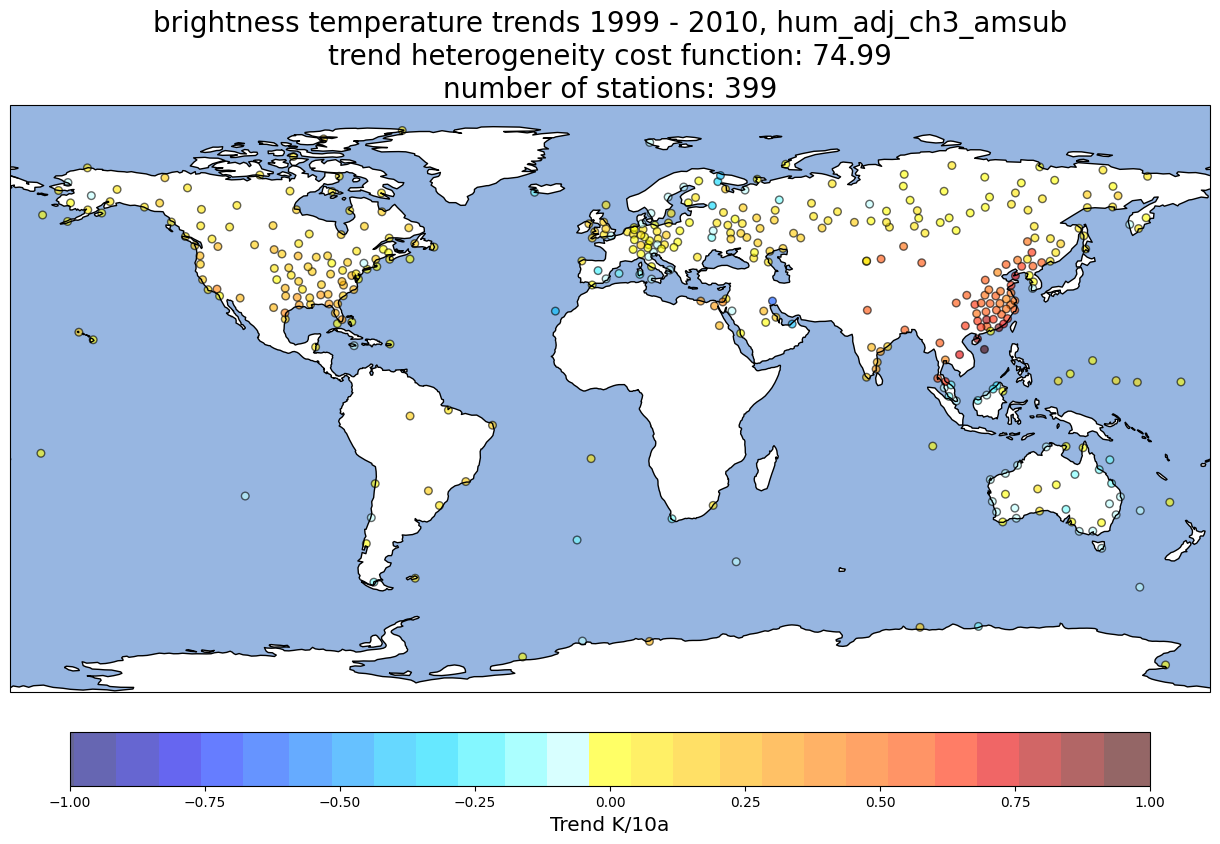

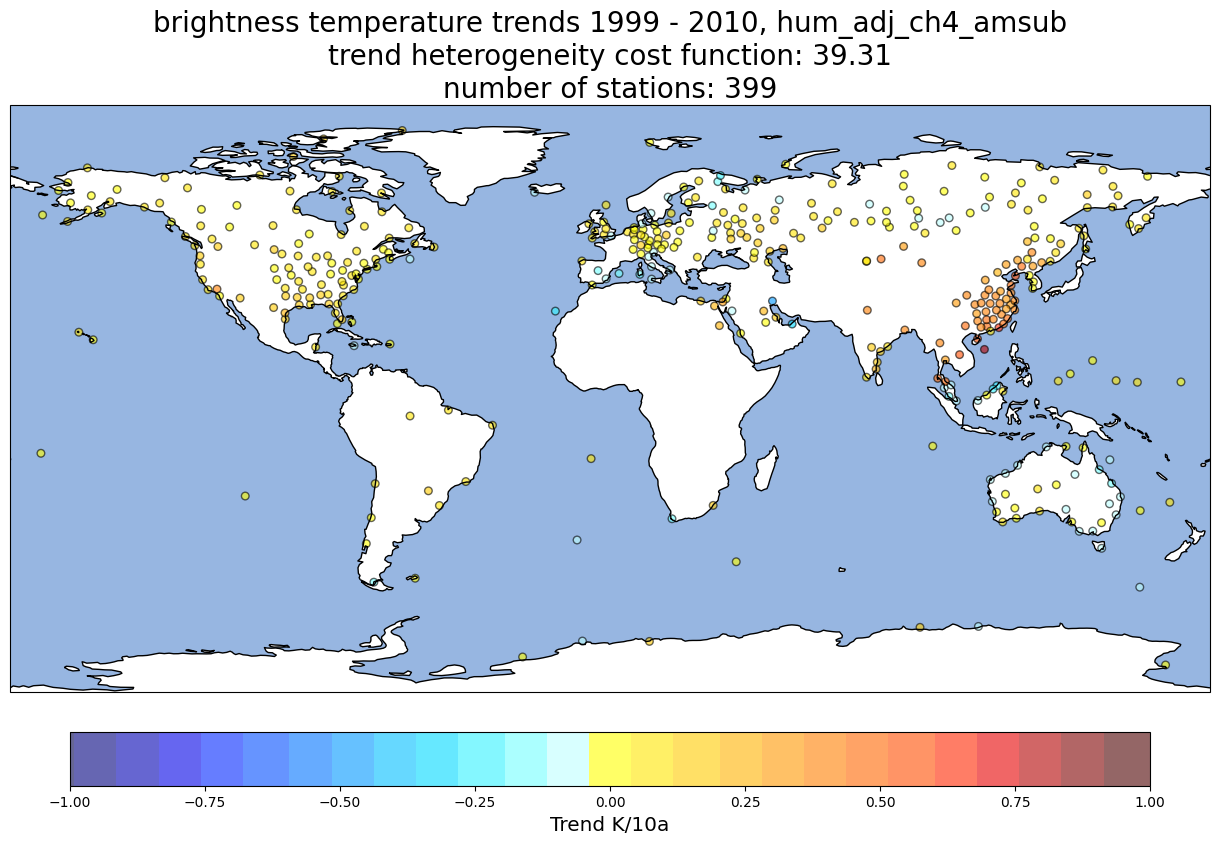

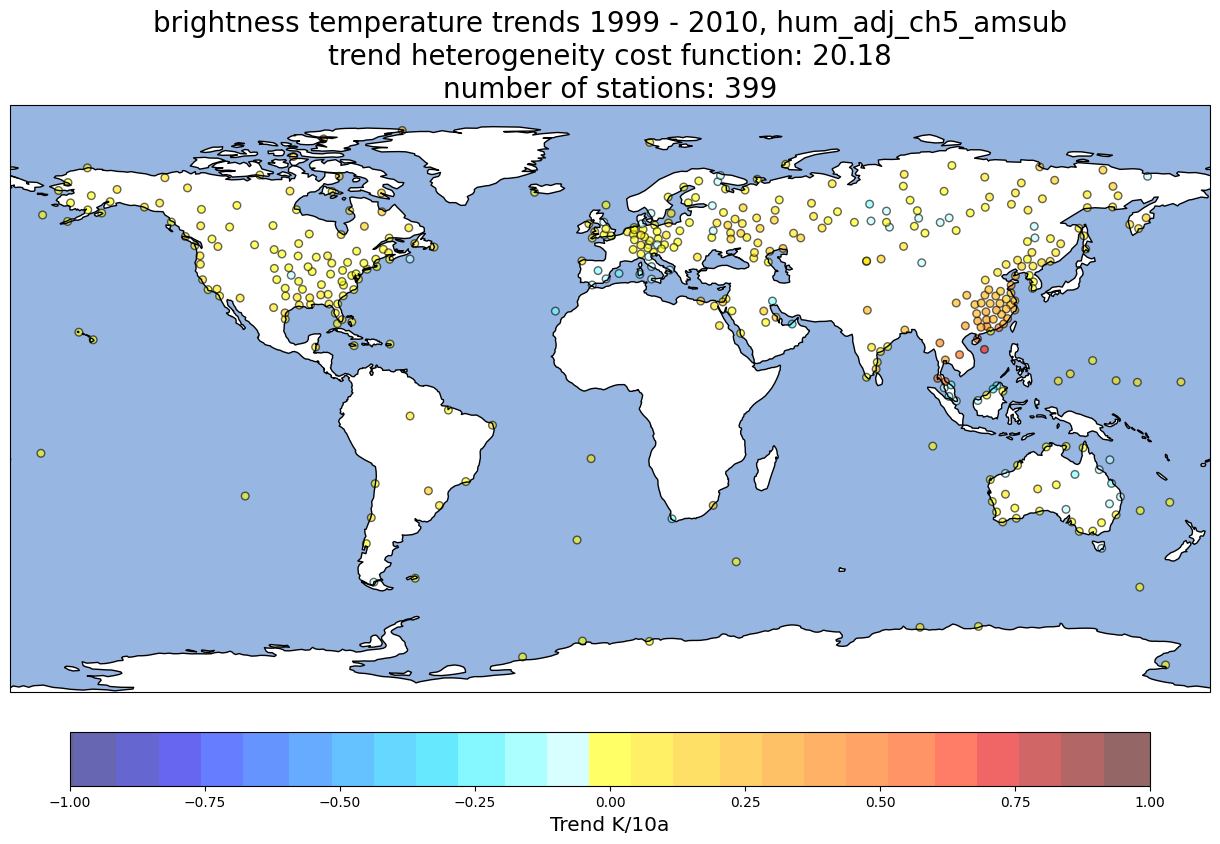

In [16]:
for k in ['ch3', 'ch4', 'ch5']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/adj/*'+k+'*amsub.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 30, marker_shape = 'o', alpha = 0.6, cold_positive=False, scale_limit=1, units = r'K/10a', titel='brightness temperature trends 1999 - 2010, ')

## GM15 12*30 - 24 months

In [13]:
# for k in ['ch3', 'ch4', 'ch5']:
#     files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/unadj/*'+k+'*.p')
#     files = np.sort(files)
#     for i in files:
#         plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 30, marker_shape = 'o', alpha = 0.6, cold_positive=True)

In [14]:
# for k in ['ch3', 'ch4', 'ch5']:
#     files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/hum_worldmap/adj/*'+k+'*.p')
#     files = np.sort(files)
#     for i in files:
#         plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 30, marker_shape = 'o', alpha = 0.6 , cold_positive=True)